In [8]:
#Stock market price predictor
#1.stock rises over a period of time
#2.stock market price estimate month wise


In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib as plt

In [66]:
#Data retriving and index manipulation
def input(label):
    ibm=yf.Ticker(label)
    ibm=ibm.history(period="max")
    ibm.to_csv("IBM_dataset")
    return ibm
ibm=input("AARTIDRUGS.NS")
ibm=ibm.loc["1990-01-01":].copy()
ibm.index=pd.to_datetime(ibm.index)
ibm.index=ibm.index.date
ibm=ibm.drop(columns=["Dividends" ,"Stock Splits"],errors="ignore")

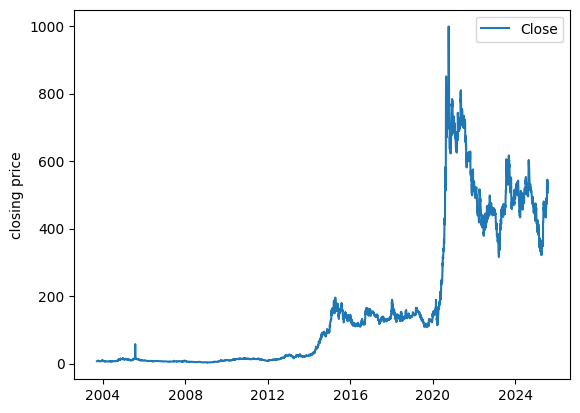

In [67]:
def datavisualisation(dataset):
    dataset.plot.line(y="Close" , ylabel="closing price",legend=["Close"],use_index=True)
datavisualisation(ibm)

In [68]:
#Data splitting 
train=ibm.iloc[:-100]
test=ibm.iloc[-100:]

feature=["High","Open","Low","Volume","Close"]
ibm["Tommorrow"]=ibm["Close"].shift(-1)
ibm["Target"]=(ibm["Tommorrow"]>ibm["Close"]).astype(int)
#model preparation for 1
from sklearn.ensemble import RandomForestClassifier

model=RandomForestClassifier(n_estimators=100, min_samples_split=100 ,random_state=1,n_jobs=-1)

def prediction(model , test ,train, feature):
    model.fit(train[feature],train["Target"])
    preds=model.predict_proba(test[feature])[:,1]
    preds[preds>=0.4]=1
    preds[preds<0.4]=0
    preds=pd.Series(preds,index=test.index,name="Predictions")
    preds=pd.concat((preds,test["Target"]),axis=1)
    return preds

In [69]:
#backtracking
def back_tracking(model , data ,feature ,start=2500 ,step=250):
    all_prediction=[]
    for i in range(start,data.shape[0],step):
        train=data.iloc[:i].copy()
        test=data.iloc[i:(i+step)].copy()
        predict= prediction(model,test,train,feature)
        all_prediction.append(predict)
    return pd.concat(all_prediction)
        

In [70]:
#Precision_score
predicts=back_tracking(model,ibm,feature)
from sklearn.metrics import precision_score
precision_score(predicts["Predictions"],predicts["Target"])

0.6824127906976745

In [71]:
predicts["Predictions"].value_counts()

Predictions
1.0    2014
0.0     900
Name: count, dtype: int64

<Axes: ylabel='Closing price'>

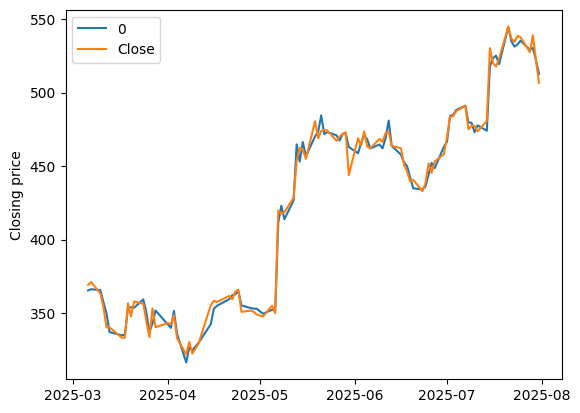

In [75]:
#model 2
from sklearn.linear_model import LinearRegression
feature=["High","Open","Low","Volume"]
m2=LinearRegression()
m2.fit(train[feature],train["Close"])

predsl=m2.predict(test[feature])
predsl=pd.Series(predsl,index=test.index)
combined=pd.concat((predsl,test["Close"]),axis=1)
combined.plot.line(ylabel="Closing prices" ,use_index=True ,legend=["Predicted","Actual"])

In [76]:
predsl

2025-03-06    365.362258
2025-03-07    366.178114
2025-03-10    365.618802
2025-03-11    357.427654
2025-03-12    349.863681
                 ...    
2025-07-25    535.436085
2025-07-28    529.143027
2025-07-29    530.528071
2025-07-30    522.341100
2025-07-31    512.822752
Length: 100, dtype: float64

In [77]:
#precision check

from sklearn.metrics import mean_squared_error ,mean_absolute_error ,r2_score

mse=mean_squared_error(test["Close"],predsl)
mae=mean_absolute_error(test["Close"],predsl)
r2_score=r2_score(test["Close"],predsl)

print("MSE :",mse)
print("MAE :",mae)
print("r2_score :",r2_score)

MSE : 28.67103643491464
MAE : 4.195954403686525
r2_score : 0.993646200297714
